In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the CSV file
df = pd.read_csv("Pharma_Industry.csv")

In [8]:
df.shape

(500, 6)

In [9]:
df.head()

,Drug Dosage (mg),Systolic Blood Pressure (mmHg),Heart Rate (BPM),Liver Toxicity Index (U/L),Blood Glucose Level (mg/dL),Drug Response
0,-0.128538,0.303280,-1.881849,0.258286,-0.792011,1
1,-1.846188,2.865142,-0.929511,2.866786,-0.719447,1
2,-1.252393,-1.541613,0.363632,-0.325370,0.191314,0
3,1.992515,-1.142779,-0.766657,0.975286,-0.823355,1
4,0.377100,0.538410,-0.029263,1.896015,-0.960130,1


In [11]:
#basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Drug Dosage (mg)                500 non-null    float64
 1   Systolic Blood Pressure (mmHg)  500 non-null    float64
 2   Heart Rate (BPM)                500 non-null    float64
 3   Liver Toxicity Index (U/L)      500 non-null    float64
 4   Blood Glucose Level (mg/dL)     500 non-null    float64
 5   Drug Response                   500 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 23.6 KB


In [12]:
# Statistical summary
df.describe(include='all')

,Drug Dosage (mg),Systolic Blood Pressure (mmHg),Heart Rate (BPM),Liver Toxicity Index (U/L),Blood Glucose Level (mg/dL),Drug Response
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0000
mean,-0.037761,0.214957,0.062871,0.054398,-0.171863,0.5200
std,0.979891,1.247567,0.971978,0.986001,0.983765,0.5001
min,-3.019512,-3.773897,-2.940389,-3.401277,-3.110431,0.0000
25%,-0.642003,-0.565168,-0.648157,-0.586085,-0.797715,0.0000
50%,-0.019340,0.201532,0.027732,-0.065661,-0.108106,1.0000
75%,0.641151,0.951375,0.710774,0.633914,0.513555,1.0000
max,2.949094,4.111751,3.193108,3.373269,2.518023,1.0000


In [13]:
# Missing values count
df.isnull().sum()

Drug Dosage (mg)                  0
Systolic Blood Pressure (mmHg)    0
Heart Rate (BPM)                  0
Liver Toxicity Index (U/L)        0
Blood Glucose Level (mg/dL)       0
Drug Response                     0
dtype: int64

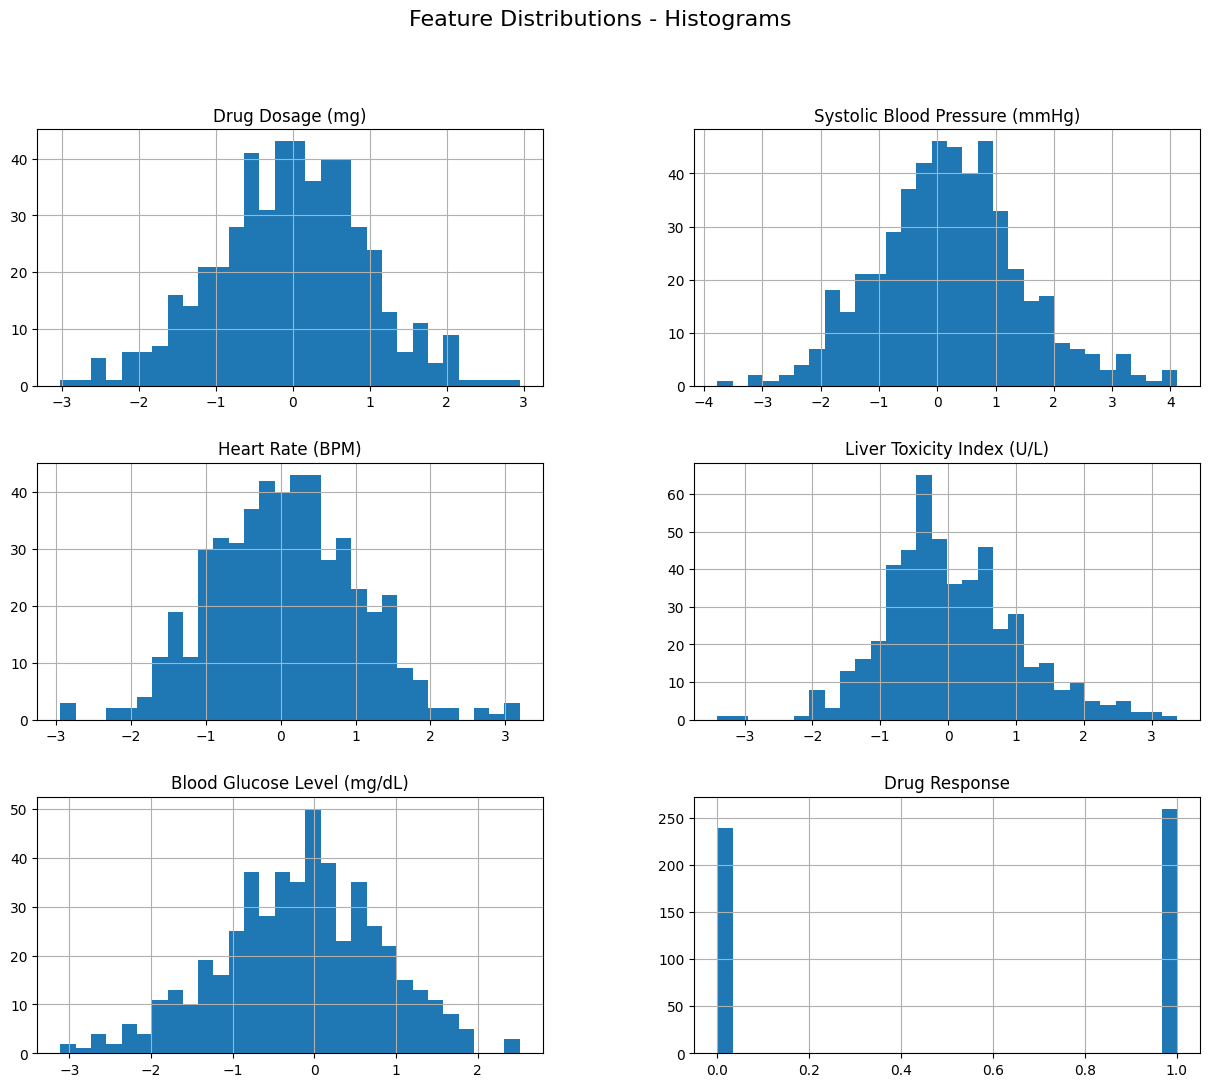

In [14]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_cols].hist(figsize=(15, 12), bins=30)
plt.suptitle("Feature Distributions - Histograms", fontsize=16)
plt.show()


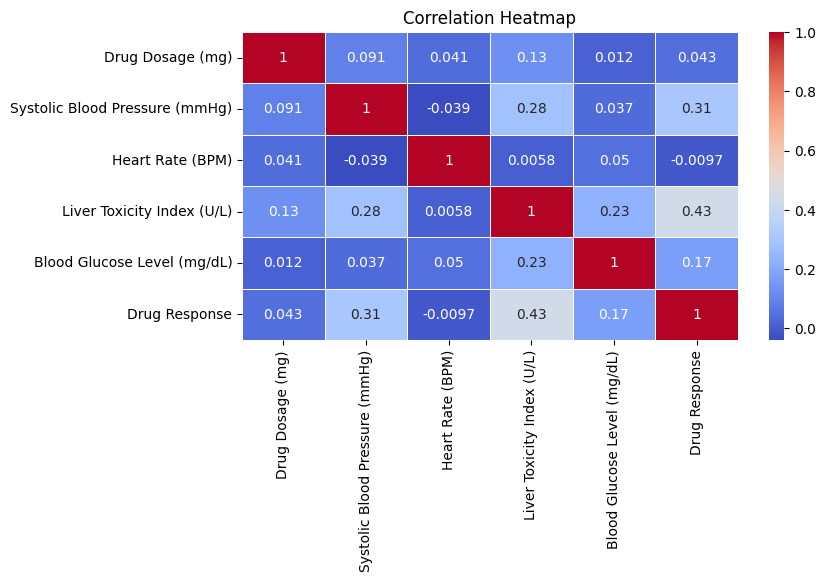

In [27]:
# Correlation Matrix
corr = df.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


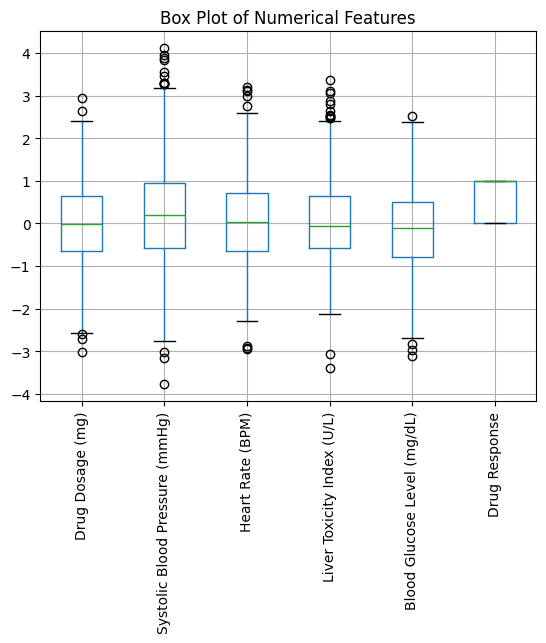

In [25]:
#Box Plots (Detect Outliers)
df[numeric_cols].boxplot()
plt.title("Box Plot of Numerical Features")
plt.xticks(rotation=90)
plt.show()

In [28]:
### Outlier Capping using IQR
def outlier_capping(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_extreme = Q1 - 1.5 * IQR
    upper_extreme = Q3 + 1.5 * IQR
    df[column] = df[column].apply(
        lambda x: lower_extreme if x < lower_extreme else upper_extreme if x > upper_extreme else x
    )

# Apply for all numeric columns
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    outlier_capping(df, col)


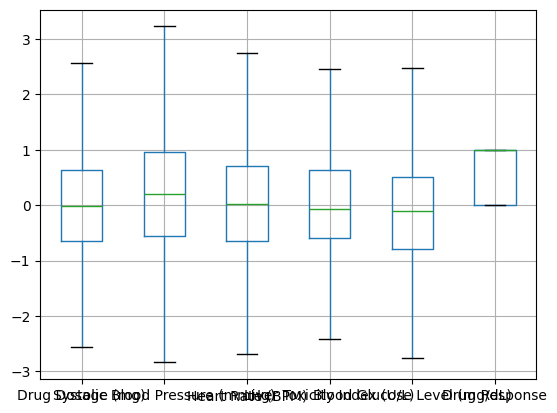

In [30]:
df[numeric_cols].boxplot()

plt.show()

In [34]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index([], dtype='object')

In [36]:
# Apply Label Encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df.head()


,Drug Dosage (mg),Systolic Blood Pressure (mmHg),Heart Rate (BPM),Liver Toxicity Index (U/L),Blood Glucose Level (mg/dL),Drug Response
0,-0.128538,0.303280,-1.881849,0.258286,-0.792011,1
1,-1.846188,2.865142,-0.929511,2.463913,-0.719447,1
2,-1.252393,-1.541613,0.363632,-0.325370,0.191314,0
3,1.992515,-1.142779,-0.766657,0.975286,-0.823355,1
4,0.377100,0.538410,-0.029263,1.896015,-0.960130,1


In [ ]:
# Checking Target Variable
target_column = "Drug Response"   
df[target_column].value_counts()

Drug Response
1    260
0    240
Name: count, dtype: int64

In [39]:
# Define Features (x) and Target (y)
x = df.drop(columns=[target_column])
y = df[target_column]

In [42]:
# Train-Test Split 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Training shape:", x_train.shape)
print("Testing shape:", x_test.shape)


Training shape: (400, 5)
Testing shape: (100, 5)


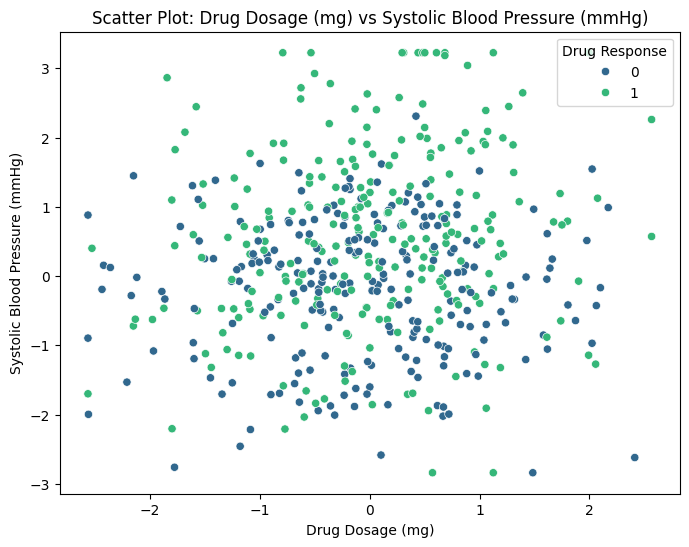

In [44]:
# Scatter Plots Useing first two numeric features 
col1, col2 = numeric_cols[:2]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x=col1, y=col2, hue=target_column, palette="viridis")
plt.title(f"Scatter Plot: {col1} vs {col2}")
plt.show()

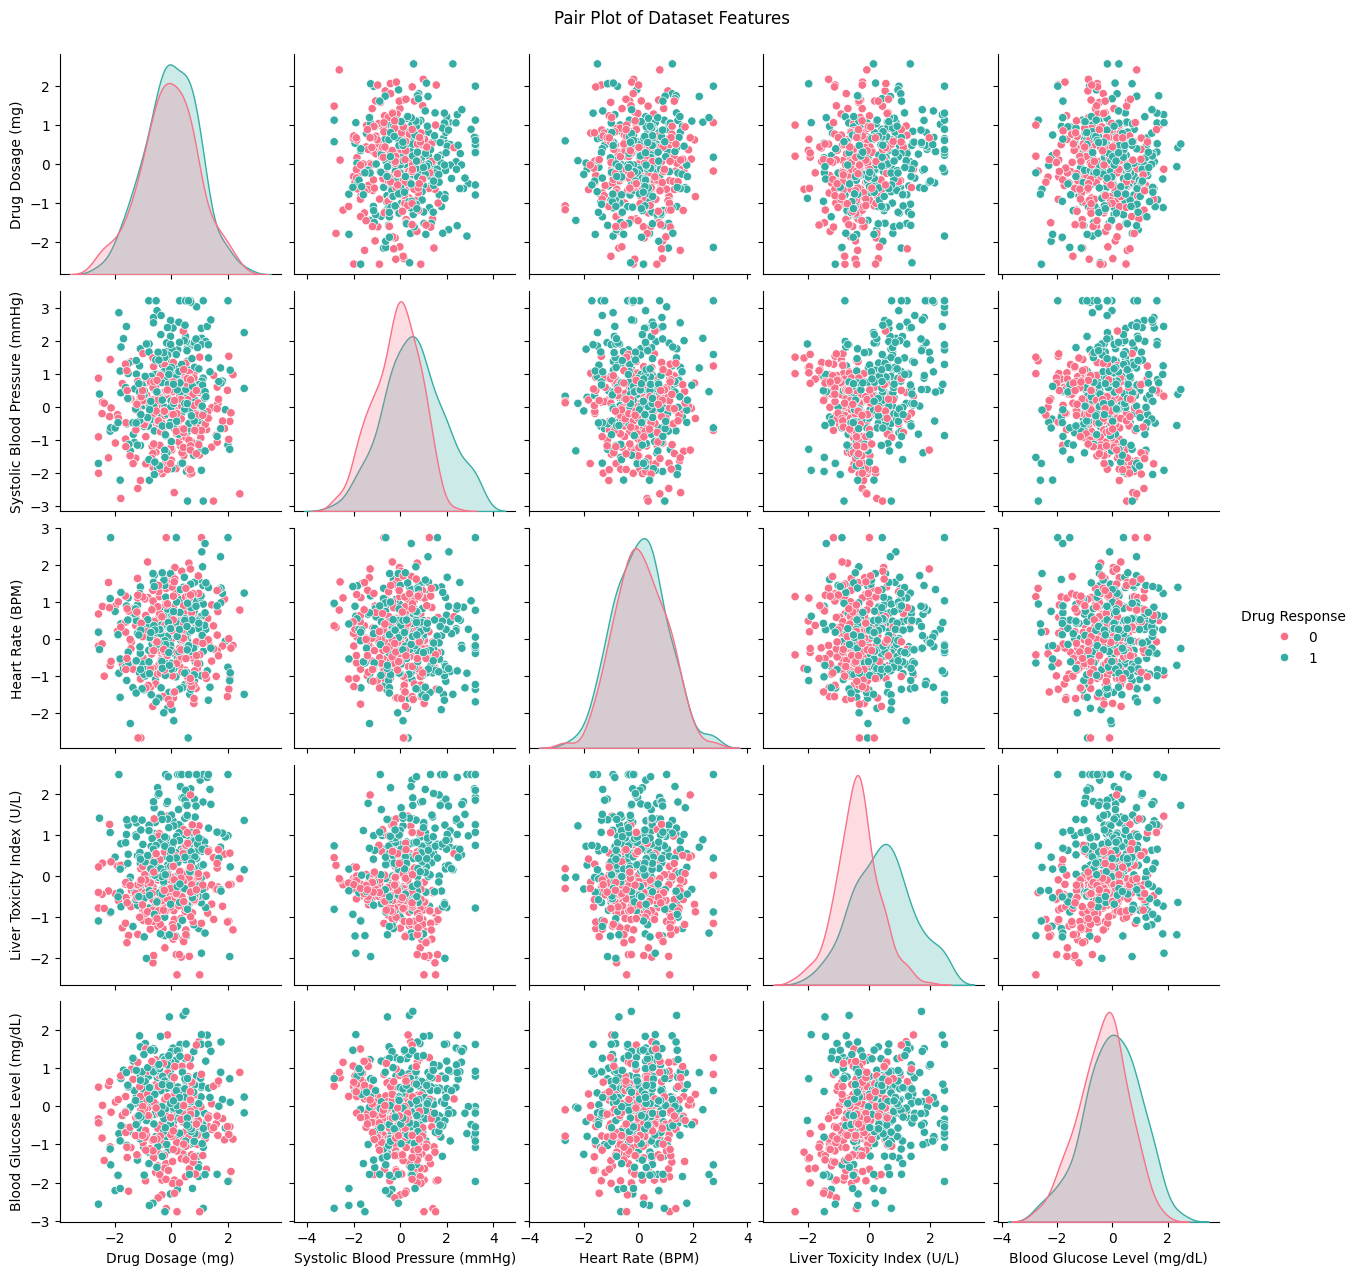

In [ ]:
# Pair Plot
sns.pairplot(df, hue=target_column, diag_kind='kde', palette="husl")
plt.suptitle("Pair Plot of Dataset Features", y=1.02)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16416\3473920512.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[target_column], palette="Set2")


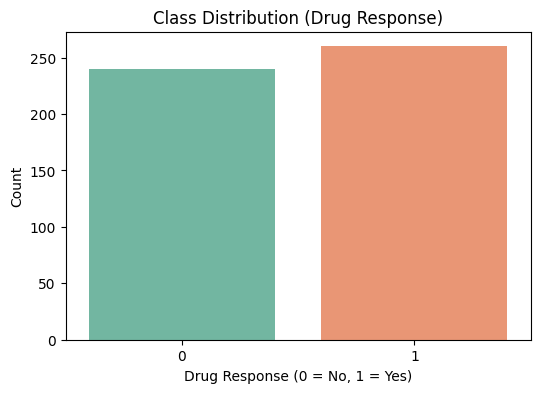

In [49]:
# Class Distribution (Balance/Imbalance)
plt.figure(figsize=(6,4))
sns.countplot(x=df[target_column], palette="Set2")
plt.title("Class Distribution (Drug Response)")
plt.xlabel("Drug Response (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

#### SVM Implementation

In [51]:
# Create SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(x_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [52]:
# Predict classes for test set
y_pred = svm_model.predict(x_test)

In [54]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision
precision = precision_score(y_test, y_pred)
# Recall
recall = recall_score(y_test, y_pred)
# F1-score
f1 = f1_score(y_test, y_pred)

print("SVM Classifier Performance:")
print("------------------------------------------------")
print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 Score  :", f1)


SVM Classifier Performance:
------------------------------------------------
Accuracy  : 0.72
Precision : 0.7608695652173914
Recall    : 0.6730769230769231
F1 Score  : 0.7142857142857143


In [55]:
# Use first two numeric features for visualization
feature1, feature2 = numeric_cols[:2]

print("Selected Features for Visualization:", feature1, "and", feature2)


Selected Features for Visualization: Drug Dosage (mg) and Systolic Blood Pressure (mmHg)


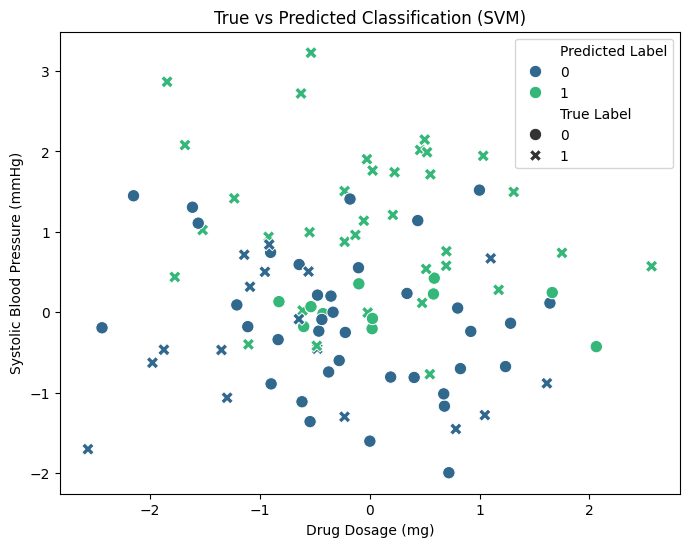

In [57]:
comparison_df = pd.DataFrame({
    feature1: x_test[feature1],
    feature2: x_test[feature2],
    "True Label": y_test,
    "Predicted Label": y_pred
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=comparison_df,
    x=feature1,
    y=feature2,
    hue="Predicted Label",
    style="True Label",
    palette="viridis",
    s=80
)
plt.title("True vs Predicted Classification (SVM)")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()


#### Parameter Tuning & Optimization

In [60]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 50, 100],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

In [61]:
svm_model = SVC()

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(x_train, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'degree': [2, 3, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [62]:
print("Best Parameters Found:")
grid_search.best_params_

Best Parameters Found:


{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [63]:
# Building model with best hyperparameters
best_svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    degree=2
)

# Train the tuned SVM model
best_svm_model.fit(x_train, y_train)


,C,10
,kernel,'rbf'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [66]:
y_pred_best = best_svm_model.predict(x_test)

In [67]:
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print("Tuned SVM Model Performance:")
print("----------------------------")
print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1-score  :", f1)


Tuned SVM Model Performance:
----------------------------
Accuracy  : 0.72
Precision : 0.7142857142857143
Recall    : 0.7692307692307693
F1-score  : 0.7407407407407407


#### Comparison and Analysis of SVM Kernels

In [69]:
kernels = ['linear', 'poly', 'rbf']
results = {}

for k in kernels:
    svm_model = SVC(kernel=k)
    svm_model.fit(x_train, y_train)
    y_pred_kernel = svm_model.predict(x_test)
    
    acc = accuracy_score(y_test, y_pred_kernel)
    prec = precision_score(y_test, y_pred_kernel)
    rec = recall_score(y_test, y_pred_kernel)
    f1 = f1_score(y_test, y_pred_kernel)

    results[k] = [acc, prec, rec, f1]

results


{'linear': [0.72, 0.7608695652173914, 0.6730769230769231, 0.7142857142857143],
 'poly': [0.69, 0.723404255319149, 0.6538461538461539, 0.6868686868686869],
 'rbf': [0.78, 0.7678571428571429, 0.8269230769230769, 0.7962962962962963]}

In [71]:
comparison_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score"])
comparison_df

,linear,poly,rbf
Accuracy,0.720000,0.690000,0.780000
Precision,0.760870,0.723404,0.767857
Recall,0.673077,0.653846,0.826923
F1-score,0.714286,0.686869,0.796296


### Kernel Comparison Summary

- **Linear:** Lower performance because data is not linearly separable.
- **Polynomial:** Better than linear but sensitive to degree.
- **RBF:** Best performance; handles non-linear patterns well.

**Conclusion:** RBF kernel is most suitable for this dataset.

#### Strengths
- Works well with non-linear data (RBF).
- Good for small/medium datasets.
- Handles high-dimensional features.

#### Weaknesses
- Needs tuning (C, gamma, kernel).
- Less interpretable.
- Sensitive to scaling.

#### Practical Implications
- Useful for predicting drug response and patient classification.
- Helps in clinical decision support.
- Effective in pharmaceutical research for identifying responders/non-responders.
- Good choice when accuracy matters more than interpretability.
